# Decile Analysis with Logistic Regression

__Import packages__

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

__Read the data__

In [3]:
# Replace this with the path to your dataset
file_path = 'bank_marketing/bank-additional/bank-additional/bank-additional-full.csv'
url = "https://raw.githubusercontent.com/selva86/datasets/master/bank-additional-full.csv"
data = pd.read_csv(url, sep=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Define Categorical variables__

In [4]:
all_vars = ['age','job','marital','education','default','housing','loan','contact','month',
 'day_of_week','duration','campaign','pdays','previous', 'poutcome','emp.var.rate',
 'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']

cat_vars = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "month", "day_of_week", "poutcome"]

__Form X and Y__

In [5]:
# Assuming the target variable is named 'converted'
X = data.drop('y', axis=1)
y = data['y'].map({"yes":1, "no":0})

__Split Training and Test__

In [8]:
# Split the data into training and testing sets
X_all = pd.concat([pd.get_dummies(X[cat_vars]),
                   X[X.columns.drop(cat_vars)]], 
                   axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(28831, 63) (12357, 63)
(28831,) (12357,)


## Step 3: Train

In [9]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Step 4: Predict Probabilities and Perform Decile Analysis

__Predict probabilities__

In [10]:
# Predict probabilities
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred_prob

array([0.07617242, 0.01116932, 0.01421718, ..., 0.01478019, 0.01250648,
       0.02918141])

__Actuals and pred probabilities__

In [11]:
# Create a dataframe with actual and predicted values
results = pd.DataFrame({'actual': y_test, 'pred_prob': y_pred_prob})
results

,actual,pred_prob
32884,0,0.076172
3169,0,0.011169
32206,0,0.014217
9403,0,0.031413
14020,0,0.019471
...,...,...
15908,0,0.018311
28222,0,0.755124
14194,0,0.014780
19764,0,0.012506


__Create the Gains Table__

In [12]:

# Rank the predictions by probability
results['rank'] = pd.qcut(results['pred_prob'], 10, labels=False)

# Calculate gains
gain = results.groupby('rank').agg(
    num_responses=('actual', 'sum'), 
    total=('actual', 'count'),
    # range_prob=('pred_prob', lambda x: (np.round(np.max(x),3), np.round(np.min(x),3)))
)

gain.sort_values(by="rank", ascending=False, inplace=True)
gain['response_rate'] = gain['num_responses'] / gain['total']
gain['cumulative_response'] = gain['num_responses'].cumsum()
gain['cumulative_response_rate'] = gain['cumulative_response'] / gain['num_responses'].sum()
gain['lift'] = gain['cumulative_response_rate'] / (gain['total'].cumsum() / gain['total'].sum())
gain = gain.reset_index()
gain

,rank,num_responses,total,response_rate,cumulative_response,cumulative_response_rate,lift
0,9,770,1236,0.622977,770,0.554356,5.542211
1,8,377,1236,0.305016,1147,0.825774,4.127868
2,7,165,1235,0.133603,1312,0.944564,3.148633
3,6,44,1236,0.035599,1356,0.976242,2.440506
4,5,17,1235,0.013765,1373,0.988481,1.977122
5,4,11,1236,0.008900,1384,0.996400,1.660712
6,3,3,1236,0.002427,1387,0.998560,1.426498
7,2,2,1235,0.001619,1389,1.000000,1.250076
8,1,0,1236,0.000000,1389,1.000000,1.111141
9,0,0,1236,0.000000,1389,1.000000,1.000000


## Step 5: Plot Gain Chart, Response Rate Chart, and Lift Curve

In [121]:
cum_response_rate = pd.concat([pd.Series([0]), 
                               gain['cumulative_response_rate']])

cum_rate = pd.concat([pd.Series([0]), gain['total'].cumsum()/gain['total'].sum()])

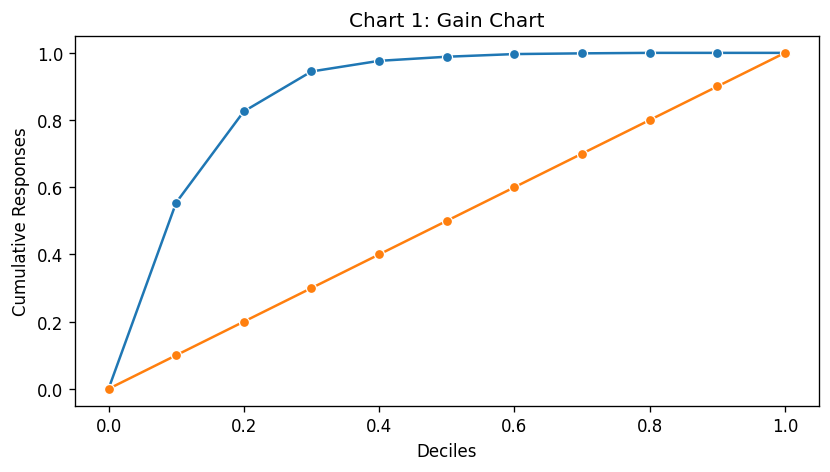

In [149]:
# Gain Chart
plt.figure(figsize=(8,4),dpi=120)
sns.lineplot(x=(np.arange(0,1.1,.1)), y=cum_response_rate, marker='o')
sns.lineplot(x=(np.arange(0,1.1,.1)), y=cum_rate, marker='o')
plt.title('Chart 1: Gain Chart')
plt.xlabel('Deciles')
plt.ylabel('Cumulative Responses')
plt.show()


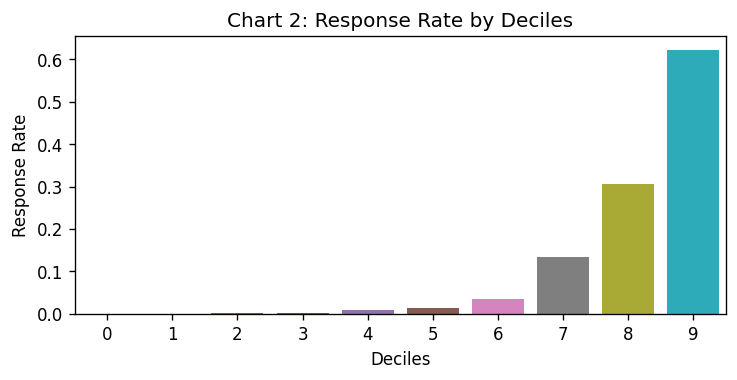

In [147]:
# Response Rate Chart
plt.figure(figsize=(7,3),dpi=120)
sns.barplot(x='rank', y='response_rate', data=gain)
plt.title('Chart 2: Response Rate by Deciles')
plt.xlabel('Deciles')
plt.ylabel('Response Rate')
plt.show()


In [134]:
gain['rank'].to_list()


[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [133]:

gain.lift[::-1]

9    1.000000
8    1.111141
7    1.250076
6    1.426498
5    1.660712
4    1.977122
3    2.440506
2    3.148633
1    4.127868
0    5.542211
Name: lift, dtype: float64

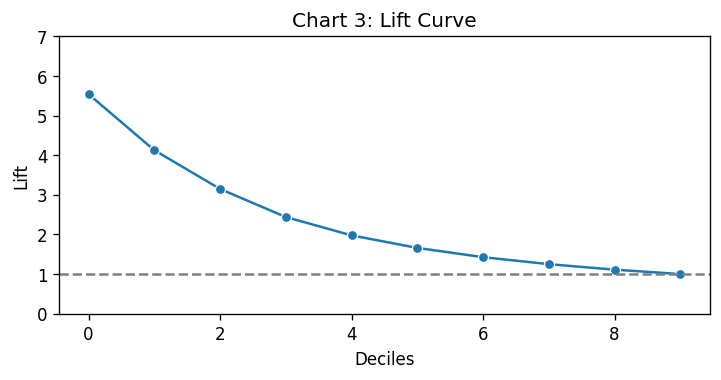

In [146]:

# Lift Curve
plt.figure(figsize=(7, 3),dpi=120)
sns.lineplot(x=gain['rank'].to_list(), y=gain.lift[::-1],marker='o')
plt.axhline(y=1, color='grey', linestyle='--')
plt.title('Chart 3: Lift Curve')
plt.ylim(0,7)
plt.xlabel('Deciles')
plt.ylabel('Lift')
plt.show()